## Разработка и обучение свёрточной нейронной сети (CNN) для классификации изображений

### Задачи

1. Разработайте архитектуру свёрточной нейронной сети для задачи классификации изображений.
Опишите ваши соображения при выборе слоев (тип, количество, последовательность) и гиперпараметров (размер фильтров, их количества, функции активации и другие).
2. Подготовьте все необходимые элементы для процесса обучения из инструментария pytorch:
загрузчики данных, необходимую функцию потерь. Загрузить данные для обучения (предобработка данных: перевод в тензорный вид, при необходимости — изменеие размеров изображений — resize).
3. Обучите модель на подготовленном наборе данных.
4. Оцените качество обучения модели на тестовой выборке
(по функции потерь — validation loss и точности — accuracy).
5. Реализуйте один (на выбор) из следующих метод борьбы с переобучением:
* cлой Dropout (если не было в разработанной архитектуре)
* cлой BatchNorm (если не было в разработанной архитектуре)
* регуляризация функции потерь,
* техники data augmentation
(дополнение данных — модификация копий изображений в обучающей выборке)
6. Подготовьте краткий отчет
(в свободной форме) с описанием выполненных шагов, архитектуры модели, процесса обучения, полученных результатов. Сделайте краткие выводы. Приложите к отчету визуализации (графики метрик обучения — loss, accuracy, примеры предсказаний сети).

In [20]:
import matplotlib.pyplot as plt
import os
import time

from typing import Iterable
from dataclasses import dataclass

import numpy as np
import torch
import torch.nn as nn
import torch.optim as O
import torch.nn.functional as F
from torch.utils.data import DataLoader as DL
from torchvision.utils import make_grid

from torchvision import datasets
from torchvision import transforms as T

__1. Разработка архитектуры свёрточной нейронной сети для задачи классификации изображений__

### Формула свертки

In [21]:
@dataclass # т.н. "декоратор", подробности: https://realpython.com/primer-on-python-decorators/
class SystemConfiguration:
    '''
    Describes the common system setting needed for reproducible training
    '''
    seed: int = 42  # seed number to set the state of all random number generators
    cudnn_benchmark_enabled: bool = True  # enable CuDNN benchmark for the sake of performance
    cudnn_deterministic: bool = True  # make cudnn deterministic (reproducible training)

**Аналогичный класс-обертка для существенных параметров процесса обучения:**


In [38]:
@dataclass
class TrainingConfiguration:
    '''
    Describes configuration of the training process
    '''
    batch_size: int = 16  # amount of data to pass through the network at each forward-backward iteration
    epochs_count: int = 10  # number of times the whole dataset will be passed through the network
    learning_rate: float = 0.001  # determines the speed of network's weights update
    log_interval: int = 100  # how many batches to wait between logging training status
    test_interval: int = 1  # how many epochs to wait before another test. Set to 1 to get val loss at each epoch
    data_root: str = "data"  # folder to save MNIST data (default: data)
    num_workers: int = 8  # number of concurrent processes used to prepare data
    device: str = "cuda"  # device to use for training.

In [39]:
# Инструмент-1: функция расчета формулы свертки

def conv_calc(data, c_out, k, p, d, s):
    
    '''
    Calculate shape for a tensor of dimension (C, H, W)
    forwarded through the conv layer with following paramters:
    k - kernel size [int, int]
    p - padding [int, int]
    d - dilation [int, int]
    s - stride [int, int]
    '''
    h_out = ((data[1] + 2 * p - d[0] * (k[0] - 1) - 1) / s[0]) + 1
    w_out = ((data[2] + 2 * p - d[1] * (k[1] - 1) - 1) / s[1]) + 1
    
    return (c_out, int(h_out), int(w_out))

In [40]:
in_dim = (3, 8, 8) # размерность входного тензора
in_dim

(3, 8, 8)

In [41]:
c_out = 12 # set to 6, in_dim[0] == in channels
k = (3,3) # set "standard" kernel size of 3x3
p = 0 # pytorch default
d = (1,1) # pytorch default
s = (1,1) # pytorch default

out = conv_calc(in_dim, c_out, k, p, d, s)
out

(12, 6, 6)

In [42]:
dir(nn)

['AdaptiveAvgPool1d',
 'AdaptiveAvgPool2d',
 'AdaptiveAvgPool3d',
 'AdaptiveLogSoftmaxWithLoss',
 'AdaptiveMaxPool1d',
 'AdaptiveMaxPool2d',
 'AdaptiveMaxPool3d',
 'AlphaDropout',
 'AvgPool1d',
 'AvgPool2d',
 'AvgPool3d',
 'BCELoss',
 'BCEWithLogitsLoss',
 'BatchNorm1d',
 'BatchNorm2d',
 'BatchNorm3d',
 'Bilinear',
 'CELU',
 'CTCLoss',
 'ChannelShuffle',
 'ConstantPad1d',
 'ConstantPad2d',
 'ConstantPad3d',
 'Container',
 'Conv1d',
 'Conv2d',
 'Conv3d',
 'ConvTranspose1d',
 'ConvTranspose2d',
 'ConvTranspose3d',
 'CosineEmbeddingLoss',
 'CosineSimilarity',
 'CrossEntropyLoss',
 'CrossMapLRN2d',
 'DataParallel',
 'Dropout',
 'Dropout1d',
 'Dropout2d',
 'Dropout3d',
 'ELU',
 'Embedding',
 'EmbeddingBag',
 'FeatureAlphaDropout',
 'Flatten',
 'Fold',
 'FractionalMaxPool2d',
 'FractionalMaxPool3d',
 'GELU',
 'GLU',
 'GRU',
 'GRUCell',
 'GaussianNLLLoss',
 'GroupNorm',
 'Hardshrink',
 'Hardsigmoid',
 'Hardswish',
 'Hardtanh',
 'HingeEmbeddingLoss',
 'HuberLoss',
 'Identity',
 'InstanceNorm1d

In [43]:
# Простейшая архитектура CNN с одним сверточным блоком как baseline
class CNN(nn.Module):
    def __init__(self):
        super().__init__() # наследование метода суперкласса (родительского класса)
        # Sequential слой - контейнер для цепи преобразующих слоев
        
        # backbone (body)
        self._body = nn.Sequential(
            # conv layer-1: input size = (32, 32), output size = (32, 32)
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
            nn.BatchNorm2d(6),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # output size = (16, 16),
              
            # conv layer-2: input size = (16,16), output size = (16, 16)
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # output size = (8, 8),

#             # conv layer-3: input size = (8,8), output size = (6, 6)
#             nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
#             nn.BatchNorm2d(32),
#             nn.LeakyReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2), # output size = (3, 3),
        )
        
        # head
        self._head = nn.Sequential(
            # in_features = total number of weight in last conv layer = 32 * 3 * 3
            nn.Linear(in_features=16*5*5, out_features=120), 
            nn.LeakyReLU(inplace=True),
            
            # in_features = output of last linear layer = 128 
            nn.Linear(in_features=120, out_features=84), 
            nn.LeakyReLU(inplace=True),
            
            # in_features = output of last linear layer = 64
            # and out_features = number of classes = 10 (CIFAR10)
            nn.Linear(in_features=84, out_features=10)
        )

    def forward(self, x):
        x = self._body(x)
        # flatten the output of conv layers
        # dimension should be batch_size * number_of weights_in_last conv_layer
        x = x.view(x.size()[0], -1)
        x = self._head(x)
        return x

**Нормализация данных**

In [44]:
# Инструмент-3: функция вычисления среднего и станадртного отклонения для 1-канального и 3-канального изображений
def get_mean_std_train_data(data_root):
    train_set = datasets.CIFAR10(root=data_root, train=True, download=True)

    r_mean = train_set.data[...,0].mean()/255 # каналы в последнем измерении
    r_std = train_set.data[...,0].std()/255
    g_mean = train_set.data[...,1].mean()/255
    g_std = train_set.data[...,1].std()/255
    b_mean = train_set.data[...,2].mean()/255
    b_std = train_set.data[...,2].std()/255

    mean = (r_mean, g_mean, b_mean)
    std = (r_std, g_std, b_std)
    
    return mean, std

**Функция для загрузки и подготовки данных:**
- Набор трансформаций (использует pytorch-класс transforms): изменяем размер всех загружаемых изображений, переводим в тензорный вид и нормализуем по известным (предоставленым в описании дататсета среднему значению и стандартному отклонению, в данном случае - MNIST).
- Загрузчик обучающей выборки (использует общий pytorch-класс загрузчика torch.utils.data.DataLoader): определяется размер батча, обязательно перемешивание элементов, число потоков процессора для загрузки данных
- Загрузчик проверочной выборки (также использует общий pytorch-класс загрузчика): также размер батча, перемешивание отсутствует, число потоков процессора

Значения аргументов будут определены позже.

In [45]:
def get_data(batch_size=TrainingConfiguration.batch_size,
             data_root=TrainingConfiguration.data_root,
             num_workers=TrainingConfiguration.num_workers):
    
    train_test_transforms = T.Compose([
        T.Resize((32, 32)), # Resize initial 28x28 size to 32X32
        T.ToTensor(), # re-scales image values [0-255] to tensor values [0-1]
        T.Normalize(*get_mean_std_train_data(data_root))  # subtract mean, divide by variance по функции выше
    ])
    
    # train dataloader
    train_loader = DL(
        datasets.CIFAR10(root=data_root, train=True, download=True,
                         transform=train_test_transforms),
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers
    )
    
    # test dataloader
    test_loader = DL(
        datasets.CIFAR10(root=data_root, train=False, download=True, transform=train_test_transforms),
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers
    )
    return train_loader, test_loader

**Визуализация датасета**

In [46]:
trans = T.ToTensor()
visual_loader = DL(
    datasets.CIFAR10(root=TrainingConfiguration.data_root, train=True,
                     download=True, transform=trans),
        batch_size=TrainingConfiguration.batch_size,
        shuffle=True,
        num_workers=TrainingConfiguration.num_workers
    )

Files already downloaded and verified


In [49]:
# Инструмент-2: функция визуализации данных
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def imshow(img):
    img = img / 2 + 0.5 # денормализуем
    npimg = img.numpy() # перевод в массив numpy
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # замена местами размерностей: C,H,W --> H,W,C (matplotlib ожидает именно так) 
    plt.show()

dataiter = iter(visual_loader) # итератор на основе загрузчика
images, labels = next(dataiter) # метод next - вызвать следующий объект итератора

imshow(make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(TrainingConfiguration.batch_size))) # bs = batch size (см выше)

KeyboardInterrupt: 

**Класс-обертка для существенных параметров окружения и их значений:**

Функция для для доступа и изменения параметров окружения:

In [50]:
def setup_system(system_config: SystemConfiguration) -> None:
    torch.manual_seed(system_config.seed)
    if torch.cuda.is_available():
        torch.backends.cudnn_benchmark_enabled = system_config.cudnn_benchmark_enabled
        torch.backends.cudnn.deterministic = system_config.cudnn_deterministic

Функция определяющая ход обучения, принимает аргуемнтами:
- имя класса-обертки с параметрами процесса обучения
- имена компонентов алгоритма обучения (загрузчики, комопненты сети, оптимизатор...)
- аргумент числа эпох (int)

In [51]:
def train(
    train_config: TrainingConfiguration, model: nn.Module, optimizer: O.Optimizer,
    train_loader: DL, epoch_idx: int
) -> None:
    
    model.train() # model in training mode
    batch_loss = np.array([])
    batch_acc = np.array([])
        
    for batch_idx, (data, target) in enumerate(train_loader):
        
        indx_target = target.clone() # clone target
        data = data.to(train_config.device)  # send data to device
        target = target.to(train_config.device) # send target to device
 
        optimizer.zero_grad() # reset parameters gradient to zero
        output = model(data) # forward pass to the model
        loss = F.cross_entropy(output, target) # cross entropy loss
        
        loss.backward() # find gradients w.r.t training parameters
        optimizer.step() # Update parameters using gradients
        
        batch_loss = np.append(batch_loss, [loss.item()]) # accumulate the loss on each batch
        
        prob = F.softmax(output, dim=1) # get probability score using soft
        pred = prob.data.max(dim=1)[1]  # get the index of the max probability
                        
        correct = pred.cpu().eq(indx_target).sum() # correct prediction
        acc = float(correct) / float(len(data)) # accuracy
        batch_acc = np.append(batch_acc, [acc]) # # accumalate the accuracy on the current batch

        if batch_idx % train_config.log_interval == 0 and batch_idx > 0:              
            print(
                'Train Epoch: {} [{}/{}] Loss: {:.6f} Acc: {:.4f}'.format(
                    epoch_idx, batch_idx * len(data), len(train_loader.dataset), loss.item(), acc
                )
            )
            
    epoch_loss = batch_loss.mean()
    epoch_acc = batch_acc.mean()
    return epoch_loss, epoch_acc

Аналогичная функция, определяющая процедуру проверки:

In [52]:
def validate(
    train_config: TrainingConfiguration,
    model: nn.Module,
    test_loader: DL,
) -> float:

    model.eval()
    test_loss = 0
    count_corect_predictions = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            
            indx_target = target.clone()
            data = data.to(train_config.device)
            target = target.to(train_config.device)
            
            output = model(data) 
            
            test_loss += F.cross_entropy(output, target).item() # add loss for each batch
            prob = F.softmax(output, dim=1) # get probs with softmax
            pred = prob.data.max(dim=1)[1] # get the index of the max prob
            count_corect_predictions += pred.cpu().eq(indx_target).sum() # add correct prediction count

        test_loss = test_loss / len(test_loader) # average over number of batches 
        accuracy = 100. * count_corect_predictions / len(test_loader.dataset) # average over number of dataset

        print(
            '\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
                test_loss, count_corect_predictions, len(test_loader.dataset), accuracy
            )
        )
    return test_loss, accuracy/100.0

### Основной цикл обучения (main loop)

- Устанавлениваем параметры окружения (CPU/GPU, число потоков процессора и т.д.)
- Загружаем данные при помощи Загрузчиков
- Созадаем экземпляр модели LeNet по ваыше описанному классу
- Указываем какой оптимизатор использовать
- Устанавливаем периоды отслеживания loss и accuracy

In [53]:
def main(
    model, 
    system_configuration=SystemConfiguration(), 
    training_configuration=TrainingConfiguration()
):
    setup_system(system_configuration) # system configuration as setted above

    # training configuration set the parameters:
    batch_size_to_set = training_configuration.batch_size # batch size
    num_workers_to_set = training_configuration.num_workers # num_workers
    epoch_num_to_set = training_configuration.epochs_count # epochs

    # if GPU is available use training config, else lower batch_size, num_workers, epochs
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
#         batch_size_to_set = 16
#         num_workers_to_set = 2
#         epoch_num_to_set = 10

    # data loader
    train_loader, test_loader = get_data(
        batch_size=batch_size_to_set,
        data_root=training_configuration.data_root,
        num_workers=num_workers_to_set
    )
    
    # Update training configuration
    training_configuration = TrainingConfiguration(
        device=device,
        epochs_count=epoch_num_to_set,
        batch_size=batch_size_to_set,
        num_workers=num_workers_to_set
    )
        
    # send model to device (GPU/CPU)
    model.to(training_configuration.device)

    # optimizer
    optimizer = O.Adam(
        model.parameters(),
        lr=training_configuration.learning_rate
    )

    best_loss = torch.tensor(np.inf) # infinity
    
    # arrays for storing the values per epoch
    epoch_train_loss = np.array([])
    epoch_test_loss = np.array([])
    epoch_train_acc = np.array([])
    epoch_test_acc = np.array([])
   
    t_begin = time.time()  # trainig time measurement
    for epoch in range(training_configuration.epochs_count):
        
        train_loss, train_acc = train(training_configuration, model, optimizer, train_loader, epoch)
        epoch_train_loss = np.append(epoch_train_loss, [train_loss])
        epoch_train_acc = np.append(epoch_train_acc, [train_acc])

        elapsed_time = time.time() - t_begin
        speed_epoch = elapsed_time / (epoch + 1)
        speed_batch = speed_epoch / len(train_loader)
        eta = speed_epoch * training_configuration.epochs_count - elapsed_time
        
        print(
            "Elapsed {:.2f}s, {:.2f} s/epoch, {:.2f} s/batch, ets {:.2f}s".format(
                elapsed_time, speed_epoch, speed_batch, eta
            )
        )

        if epoch % training_configuration.test_interval == 0:
            
            current_loss, current_accuracy = validate(training_configuration, model, test_loader)
            epoch_test_loss = np.append(epoch_test_loss, [current_loss])
            epoch_test_acc = np.append(epoch_test_acc, [current_accuracy])
            
            if current_loss < best_loss:
                best_loss = current_loss
                
    print("Total time: {:.2f}, Best Loss: {:.3f}".format(time.time() - t_begin, best_loss))
    
    return model, epoch_train_loss, epoch_train_acc, epoch_test_loss, epoch_test_acc

### Запуск main loop

In [54]:
model = CNN()
model, epoch_train_loss, epoch_train_acc, epoch_test_loss, epoch_test_acc = main(model)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Train Epoch: 0 [1600/50000] Loss: 2.120694 Acc: 0.1875
Train Epoch: 0 [3200/50000] Loss: 1.621562 Acc: 0.5000
Train Epoch: 0 [4800/50000] Loss: 1.586351 Acc: 0.4375
Train Epoch: 0 [6400/50000] Loss: 1.360912 Acc: 0.3750
Train Epoch: 0 [8000/50000] Loss: 2.069651 Acc: 0.1250
Train Epoch: 0 [9600/50000] Loss: 1.564322 Acc: 0.4375
Train Epoch: 0 [11200/50000] Loss: 1.681217 Acc: 0.3750
Train Epoch: 0 [12800/50000] Loss: 1.573342 Acc: 0.3750
Train Epoch: 0 [14400/50000] Loss: 1.936904 Acc: 0.2500
Train Epoch: 0 [16000/50000] Loss: 1.278155 Acc: 0.6250
Train Epoch: 0 [17600/50000] Loss: 1.705123 Acc: 0.4375
Train Epoch: 0 [19200/50000] Loss: 1.669419 Acc: 0.4375
Train Epoch: 0 [20800/50000] Loss: 1.203783 Acc: 0.5625
Train Epoch: 0 [22400/50000] Loss: 1.401122 Acc: 0.4375
Train Epoch: 0 [24000/50000] Loss: 1.585704 Acc: 0.3750
Train Epoch: 0 [25600/50000] Loss: 1.282107 Acc: 0.5

Train Epoch: 4 [22400/50000] Loss: 0.711029 Acc: 0.6250
Train Epoch: 4 [24000/50000] Loss: 0.799697 Acc: 0.6250
Train Epoch: 4 [25600/50000] Loss: 0.974422 Acc: 0.7500
Train Epoch: 4 [27200/50000] Loss: 0.840367 Acc: 0.6875
Train Epoch: 4 [28800/50000] Loss: 0.869982 Acc: 0.6250
Train Epoch: 4 [30400/50000] Loss: 1.476687 Acc: 0.5625
Train Epoch: 4 [32000/50000] Loss: 0.448501 Acc: 0.8125
Train Epoch: 4 [33600/50000] Loss: 1.322404 Acc: 0.5625
Train Epoch: 4 [35200/50000] Loss: 0.799411 Acc: 0.6875
Train Epoch: 4 [36800/50000] Loss: 1.126039 Acc: 0.6250
Train Epoch: 4 [38400/50000] Loss: 1.137652 Acc: 0.5625
Train Epoch: 4 [40000/50000] Loss: 1.413939 Acc: 0.5625
Train Epoch: 4 [41600/50000] Loss: 0.923632 Acc: 0.6250
Train Epoch: 4 [43200/50000] Loss: 1.308745 Acc: 0.5625
Train Epoch: 4 [44800/50000] Loss: 1.041462 Acc: 0.6875
Train Epoch: 4 [46400/50000] Loss: 0.617070 Acc: 0.8125
Train Epoch: 4 [48000/50000] Loss: 0.739226 Acc: 0.6250
Train Epoch: 4 [49600/50000] Loss: 0.665677 Acc:

Train Epoch: 8 [46400/50000] Loss: 0.271832 Acc: 0.8750
Train Epoch: 8 [48000/50000] Loss: 1.416254 Acc: 0.5000
Train Epoch: 8 [49600/50000] Loss: 0.686469 Acc: 0.7500
Elapsed 1237.42s, 137.49 s/epoch, 0.04 s/batch, ets 137.49s

Test set: Average loss: 1.0080, Accuracy: 6572/10000 (66%)

Train Epoch: 9 [1600/50000] Loss: 0.563888 Acc: 0.8125
Train Epoch: 9 [3200/50000] Loss: 0.509211 Acc: 0.8125
Train Epoch: 9 [4800/50000] Loss: 0.793890 Acc: 0.6875
Train Epoch: 9 [6400/50000] Loss: 0.479368 Acc: 0.8125
Train Epoch: 9 [8000/50000] Loss: 0.553762 Acc: 0.8125
Train Epoch: 9 [9600/50000] Loss: 0.748261 Acc: 0.6875
Train Epoch: 9 [11200/50000] Loss: 0.195312 Acc: 1.0000
Train Epoch: 9 [12800/50000] Loss: 0.594338 Acc: 0.7500
Train Epoch: 9 [14400/50000] Loss: 0.890551 Acc: 0.6875
Train Epoch: 9 [16000/50000] Loss: 0.799105 Acc: 0.7500
Train Epoch: 9 [17600/50000] Loss: 0.791025 Acc: 0.6875
Train Epoch: 9 [19200/50000] Loss: 0.924938 Acc: 0.6875
Train Epoch: 9 [20800/50000] Loss: 0.761135 A

### 20 эпох:
- на GPU (RTX 3070 notebook) = 336 сек
- на СPU (Intel i7) = 397 сек

Text(0.5, 1.0, 'Training and Validation Accuracy')

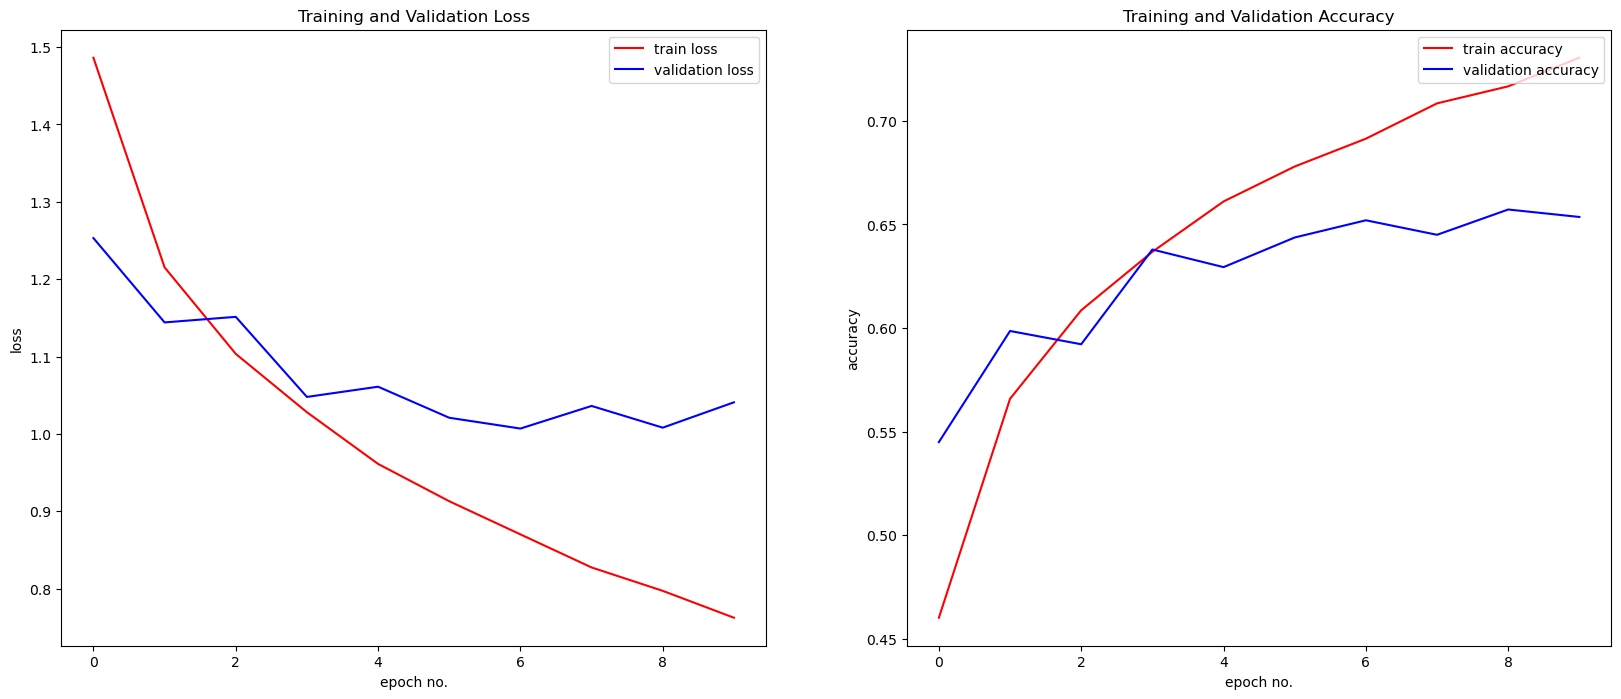

In [56]:
# Plot loss
plt.rcParams["figure.figsize"] = (10, 6)
x_loss = range(len(epoch_train_loss))
x_acc = range(len(epoch_train_acc))

plt.figure(figsize=[20,8])
plt.subplot(121)
plt.plot(x_loss, epoch_train_loss, 'r', label="train loss")
plt.plot(x_loss, epoch_test_loss, 'b', label="validation loss")
plt.xlabel('epoch no.')
plt.ylabel('loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(122)
plt.plot(x_acc, epoch_train_acc, 'r', label="train accuracy")
plt.plot(x_acc, epoch_test_acc, 'b', label="validation accuracy")
plt.xlabel('epoch no.')
plt.ylabel('accuracy')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')

### Примененрие сети (инференс)
Берем батч из загрузчика проверочной выборки, выбираем одно изображение (по индексам), пропускаем через сеть, смотрим результат, сравниваем в предсказанным, делаем вывод.

In [57]:
check_pic_loader = DL(
    datasets.CIFAR10(root=TrainingConfiguration.data_root, train=True,
                     download=True, transform=trans),
#         batch_size=128,
        shuffle=True,
        num_workers=TrainingConfiguration.num_workers
    )

Files already downloaded and verified


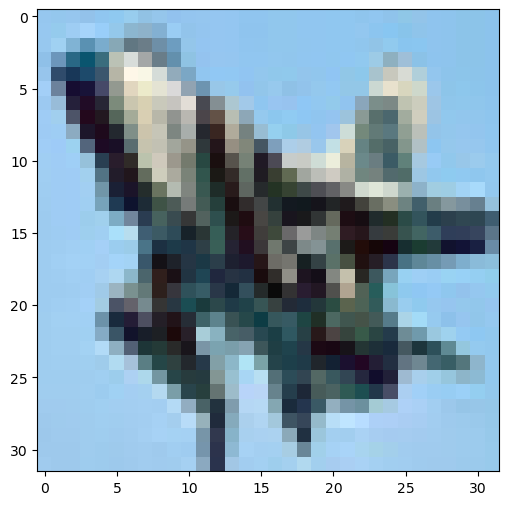

In [58]:
def imshow(img):
    npimg = img.numpy() # перевод в массив numpy
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # замена местами размерностей: C,H,W --> H,W,C (matplotlib ожидает именно так) 
    plt.show()

dataiter = iter(check_pic_loader) # итератор на основе загрузчика
image, label = next(dataiter) # метод next - вызвать следующий объект итератора

imshow(make_grid(image))

In [59]:
with torch.no_grad():
    outputs = model(image)
    print(outputs)
    # pred is the index value of the maximum value
    _, pred = torch.max(outputs,dim=1)
    pred = pred.numpy()

tensor([[ 0.3649, -3.9062, -0.7660,  0.8097, -0.7004, -0.7081, -0.5418, -3.6083,
          0.7778, -2.1520]])


In [60]:
pred

array([3], dtype=int64)

In [61]:
classes[pred[0]]

'cat'

In [62]:
classes[label]

'airplane'

In [63]:
transform = T.Compose(
    [T.Resize((32,32)),
     T.ToTensor(),
     T.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

In [64]:
from PIL import Image

# Load the picture as a PIL picture and store them as img1, img2, img3, img4
img0,img1,img2,img3 = map(Image.open,
                          ('data/dog.jpg','data/horse.jpg',
                           'data/ship.jpg','data/truck.jpg'))
                                                     
img0,img1,img2,img3 = map(transform, (img0,img1,img2,img3))

In [65]:
# Add the dimension representing the batch size
img0 = torch.unsqueeze(img0, dim=0)
img1 = torch.unsqueeze(img1, dim=0)
img2 = torch.unsqueeze(img2, dim=0)
img3 = torch.unsqueeze(img3, dim=0)
# Four pictures into one batch
images = torch.cat((img0, img1, img2, img3),dim=0)

In [66]:
with torch.no_grad():
    outputs = model(images)
    # pred is the index value of the maximum value
    _, pred = torch.max(outputs,dim=1)
    pred = pred.numpy()

In [67]:
for i in range(4):
    print(classes[pred[i]])

dog
deer
ship
frog
